Goal: Train simple GNN in DGL to classify nodes in a graph.
The tutorial is based on the “Zachary’s karate club” problem. The karate club is a social network that includes 34 members and documents pairwise links between members who interact outside the club. The club later divides into two communities led by the instructor (node 0) and the club president (node 33). The task is to predict which side (0 or 33) each member tends to join given the social network itself.

# Step 1: Create graph in DGL

In [1]:
import dgl
import numpy as np

def build_karate_club_graph():
    # all 78 edges are stored in two np arrays. One for source and one with destination endpoints
    src = np.array([1, 2, 2, 3, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 9, 10, 10,
        10, 11, 12, 12, 13, 13, 13, 13, 16, 16, 17, 17, 19, 19, 21, 21,
        25, 25, 27, 27, 27, 28, 29, 29, 30, 30, 31, 31, 31, 31, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33])
    dst = np.array([0, 0, 1, 0, 1, 2, 0, 0, 0, 4, 5, 0, 1, 2, 3, 0, 2, 2, 0, 4,
        5, 0, 0, 3, 0, 1, 2, 3, 5, 6, 0, 1, 0, 1, 0, 1, 23, 24, 2, 23,
        24, 2, 23, 26, 1, 8, 0, 24, 25, 28, 2, 8, 14, 15, 18, 20, 22, 23,
        29, 30, 31, 8, 9, 13, 14, 15, 18, 19, 20, 22, 23, 26, 27, 28, 29, 30,
        31, 32])
    # Edges are directional in DGL; Make them bi-directional.
    u = np.concatenate([src, dst])
    v = np.concatenate([dst, src])
    print(u)
    print(v)
    # construct DGL graph
    return dgl.graph((u, v))

Using backend: pytorch


In [2]:
G = build_karate_club_graph()
print(f'we have {G.number_of_nodes()} nodes.')
print(f'we have {G.number_of_edges()} edges.')

[ 1  2  2  3  3  3  4  5  6  6  6  7  7  7  7  8  8  9 10 10 10 11 12 12
 13 13 13 13 16 16 17 17 19 19 21 21 25 25 27 27 27 28 29 29 30 30 31 31
 31 31 32 32 32 32 32 32 32 32 32 32 32 33 33 33 33 33 33 33 33 33 33 33
 33 33 33 33 33 33  0  0  1  0  1  2  0  0  0  4  5  0  1  2  3  0  2  2
  0  4  5  0  0  3  0  1  2  3  5  6  0  1  0  1  0  1 23 24  2 23 24  2
 23 26  1  8  0 24 25 28  2  8 14 15 18 20 22 23 29 30 31  8  9 13 14 15
 18 19 20 22 23 26 27 28 29 30 31 32]
[ 0  0  1  0  1  2  0  0  0  4  5  0  1  2  3  0  2  2  0  4  5  0  0  3
  0  1  2  3  5  6  0  1  0  1  0  1 23 24  2 23 24  2 23 26  1  8  0 24
 25 28  2  8 14 15 18 20 22 23 29 30 31  8  9 13 14 15 18 19 20 22 23 26
 27 28 29 30 31 32  1  2  2  3  3  3  4  5  6  6  6  7  7  7  7  8  8  9
 10 10 10 11 12 12 13 13 13 13 16 16 17 17 19 19 21 21 25 25 27 27 27 28
 29 29 30 30 31 31 31 31 32 32 32 32 32 32 32 32 32 32 32 33 33 33 33 33
 33 33 33 33 33 33 33 33 33 33 33 33]
we have 34 nodes.
we have 156 edges.


## Visualize graph by converting to networkx graph

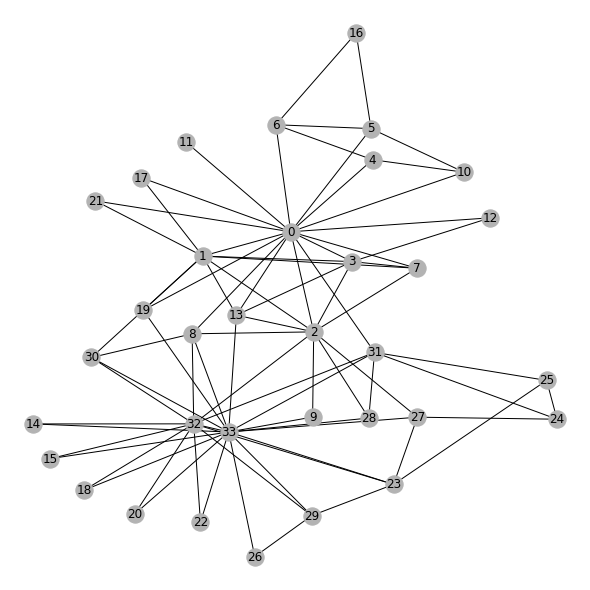

In [3]:
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 8))
nx_G = G.to_networkx().to_undirected()
pos = nx.kamada_kawai_layout(nx_G) # arbitrary graph layout 
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

# Step 2: Assign features to nodes or edges

Graph neural networks associate features with nodes and edges for training. For our classification example, since there is no input feature, we assign each node with a learnable embedding vector.

In [4]:
# In DGL, you can add features for all nodes at once, using a feature tensor that
# batches node features along the first dimension. The code below adds the learnable
# embeddings for all nodes:

import torch
import torch.nn as nn
import torch.nn.functional as F

embed = nn.Embedding(34, 5) # 34 nodes with embedding dim = 5
G.ndata['feat'] = embed.weight

# print out input features of node 2
print(G.ndata['feat'][2])

#print out node 10 and 11's input features
print(G.ndata['feat'][[10, 11]])

tensor([ 0.7078,  1.1195,  0.1772,  0.9603, -0.4445], grad_fn=<SelectBackward>)
tensor([[ 0.2297, -1.2118,  0.6782, -2.6136, -0.1505],
        [ 0.1684,  1.8005,  0.7112,  0.4486,  0.4262]],
       grad_fn=<IndexBackward>)


# Step 3: Define a Graph Convolutional Network (GCN)

To perform node classification, use the Graph Convolutional Network (GCN) developed by [Kipf and Welling](https://arxiv.org/abs/1609.02907)

In [5]:
from dgl.nn.pytorch import GraphConv

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(input_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, num_classes)
        
    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h
    
# The first layer transforms input features of size of 5 to a hidden size of 10.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(5, 10, 2)

# Step 4: Data preparation and initialization

We use learnable embeddings to initialize the node features. Since this is a semi-supervised setting, only the instructor (node 0) and the club president (node 33) are assigned labels. The implementation is available as follow.

In [6]:
input_features = embed.weight
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

# Step 5: Train

The training loop is exactly the same as other PyTorch models. 
1. Create an optimizer 
2. Feed the inputs to the model
3. Calculate the loss 
4. Use autograd to optimize the model.

In [7]:
import itertools

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []
epochs = 50

for epoch in range(epochs):
    logits = net(G, input_features)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(f'Epoch {epoch} | Loss: {loss.item():.4f}')

Epoch 0 | Loss: 0.8002
Epoch 1 | Loss: 0.7350
Epoch 2 | Loss: 0.6718
Epoch 3 | Loss: 0.6140
Epoch 4 | Loss: 0.5592
Epoch 5 | Loss: 0.5081
Epoch 6 | Loss: 0.4606
Epoch 7 | Loss: 0.4169
Epoch 8 | Loss: 0.3764
Epoch 9 | Loss: 0.3391
Epoch 10 | Loss: 0.3048
Epoch 11 | Loss: 0.2732
Epoch 12 | Loss: 0.2434
Epoch 13 | Loss: 0.2155
Epoch 14 | Loss: 0.1900
Epoch 15 | Loss: 0.1669
Epoch 16 | Loss: 0.1458
Epoch 17 | Loss: 0.1269
Epoch 18 | Loss: 0.1100
Epoch 19 | Loss: 0.0951
Epoch 20 | Loss: 0.0819
Epoch 21 | Loss: 0.0704
Epoch 22 | Loss: 0.0604
Epoch 23 | Loss: 0.0518
Epoch 24 | Loss: 0.0445
Epoch 25 | Loss: 0.0382
Epoch 26 | Loss: 0.0328
Epoch 27 | Loss: 0.0283
Epoch 28 | Loss: 0.0244
Epoch 29 | Loss: 0.0211
Epoch 30 | Loss: 0.0184
Epoch 31 | Loss: 0.0160
Epoch 32 | Loss: 0.0141
Epoch 33 | Loss: 0.0124
Epoch 34 | Loss: 0.0110
Epoch 35 | Loss: 0.0098
Epoch 36 | Loss: 0.0087
Epoch 37 | Loss: 0.0078
Epoch 38 | Loss: 0.0071
Epoch 39 | Loss: 0.0064
Epoch 40 | Loss: 0.0058
Epoch 41 | Loss: 0.0053
Ep

# Visualize

This is a rather toy example, so it does not even have a validation or test set. Instead, Since the model produces an output feature of size 2 for each node, we can visualize by plotting the output feature in a 2D space. The following code animates the training process from initial guess (where the nodes are not classified correctly at all) to the end (where the nodes are linearly separable).

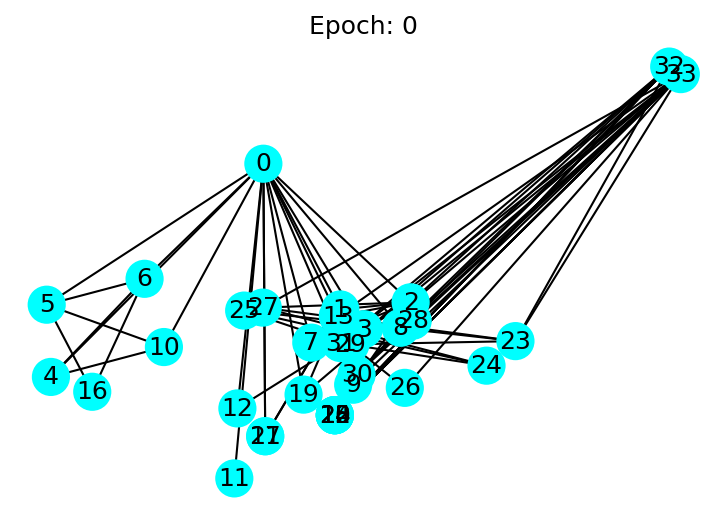

In [8]:
def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else  cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title(f'Epoch: {i}')
    nx.draw_networkx(nx_G, pos, node_color=colors, with_labels=True, node_size=300, ax=ax)
    
fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)  # draw the prediction of the first epoch


In [10]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

anim = FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
anim.save('filename.gif', writer='imagemagick')
HTML(anim.to_html5_video())